<a href="https://colab.research.google.com/github/Harshitha-141103/Crypto-currency-prediction/blob/main/NOTEBOOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6  # Sets the default figure size for plots to 15x6 inches

from sklearn.preprocessing import MinMaxScaler  # Imports MinMaxScaler to normalize data between 0 and 1

from keras.models import Sequential  # Imports Sequential model from Keras for building the neural network
from keras.layers import Dense  # Imports Dense (fully connected) layer for output processing
from keras.layers import LSTM, GRU  # Imports LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) for handling sequential data
from keras.layers import Dropout  # Imports Dropout to prevent overfitting

from math import sqrt  # Imports square root function

import math  # Imports math module for mathematical operations
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Imports error metrics to evaluate model performance


NumPy & Pandas: Used for data handling.
Matplotlib & Seaborn: Used for visualization.
Lag Plot: Helps in time series analysis.
OS & subprocess: Useful for interacting with files and running shell commands.
Warnings: Can be used to suppress warnings.

In [2]:
import numpy as np  # Imports NumPy for numerical computations
import pandas as pd  # Imports Pandas for handling and processing data

import matplotlib.pyplot as plt  # Imports Matplotlib for data visualization
from pandas.plotting import lag_plot  # Imports lag_plot to visualize autocorrelation in time series data
from datetime import datetime  # Imports datetime module for handling date and time-related operations

from sklearn.metrics import mean_squared_error  # Imports mean squared error (MSE) for model evaluation

import os  # Imports OS module for interacting with the operating system
from subprocess import check_output  # Imports check_output to run shell commands

import seaborn as sns  # Imports Seaborn for advanced statistical data visualization
import matplotlib.pyplot as plt  # Re-imports Matplotlib (this line is redundant)
import warnings  # Imports warnings module to manage warning messages
from pandas.plotting import lag_plot  # Re-imports lag_plot (this line is redundant)

Date Parsing: The dateparse function converts date strings into datetime objects.
CSV Loading: The dataset is loaded with pandas.read_csv(), and the 'Date' column is set as the index.
Plotting: A time series line plot is created to visualize the trend of Tesla's opening prices.

In [3]:
from datetime import datetime  # Imports datetime module to handle date parsing

# Defines a lambda function to convert date strings ('YYYY-MM-DD') into datetime objects
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')

# Reads the CSV file containing Tesla stock data
data = pd.read_csv('/content/TSLA.csv',   # File path (adjust if needed)
                   sep=',',               # Specifies comma as the delimiter
                   parse_dates=['Date'],  # Converts the 'Date' column into datetime format
                   index_col='Date',      # Sets 'Date' as the index for time series analysis
                   date_parser=dateparse) # Uses the custom date parsing function

# Creates a plot with a figure size of 16x8 inches
plt.figure(figsize=(16,8))
plt.grid(True)  # Adds a grid to the plot for better readability
plt.xlabel('Dates')  # Sets the x-axis label
plt.ylabel('Open Prices')  # Sets the y-axis label
plt.plot(data['Open'])  # Plots the 'Open' prices from the dataset


FileNotFoundError: [Errno 2] No such file or directory: '/content/TSLA.csv'

Lag Plot: Visualizes the relationship between today's and yesterday's prices.
Lagged DataFrame: Shifts prices by 120 days to create a time-lagged dataset.
Correlation Analysis: Measures how past prices (120 days ago) influence current prices.

<ipython-input-5-0ef465671144>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();  # Adds a legend (not needed here as there are no labeled plots)


          t-1       t+1
t-1  1.000000 -0.009424
t+1 -0.009424  1.000000


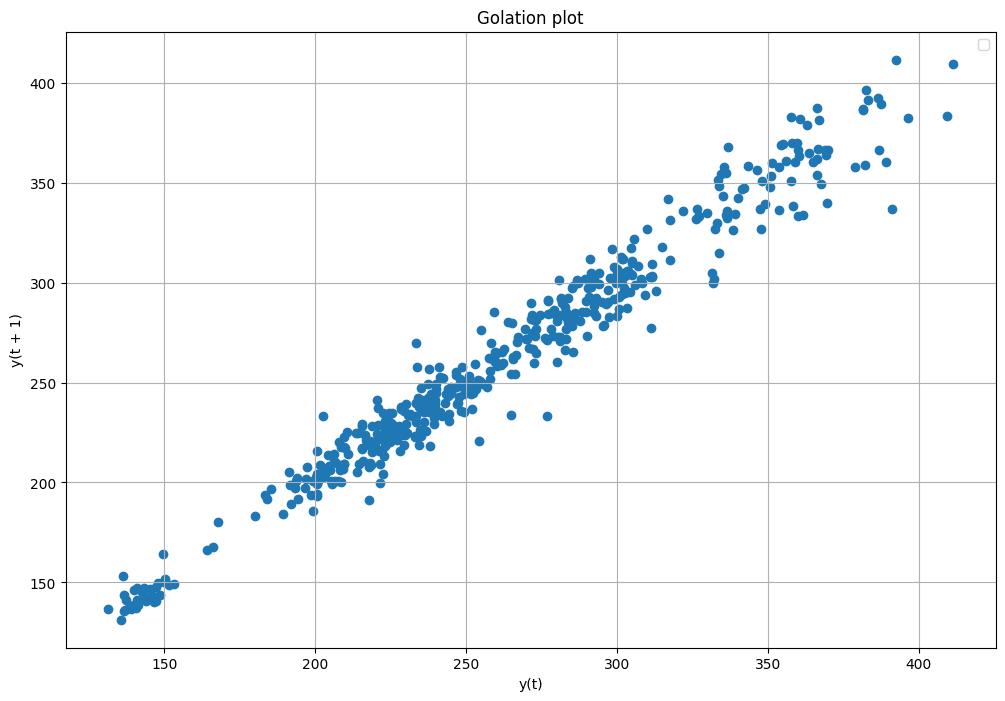

In [ ]:
from pandas.plotting import lag_plot  # Imports lag_plot for visualizing autocorrelation

# Creates a lag plot to observe relationships between consecutive time points
plt.figure(figsize=(12,8))  # Sets figure size
lag_plot(data['Open'], lag=1)  # Plots the 'Open' prices with a lag of 1 day
plt.title('Golation plot')  # Sets the plot title (likely a typo, should be 'Correlation plot')
plt.grid(True)  # Adds a grid for better readability
plt.legend();  # Adds a legend (not needed here as there are no labeled plots)

from pandas import DataFrame, concat  # Imports DataFrame and concat for data manipulation

# Converts 'Open' prices into a DataFrame
values = DataFrame(data['Open'].values)

# Creates a lagged dataset by shifting values 120 days backward
dataframe = concat([values.shift(120), values], axis=1)

# Renames columns: 't-1' represents past values (120 days ago), 't+1' represents current values
dataframe.columns = ['t-1', 't+1']

# Computes the correlation between past and current values
result = dataframe.corr()
print(result)  # Prints the correlation matrix


Data Splitting: The first 90% of the dataset is used for training, while the last 10% is used for testing.

Visualization:
Green represents the training data.
Blue represents the test data.

Purpose: This helps in understanding how much data is used for training versus testing.

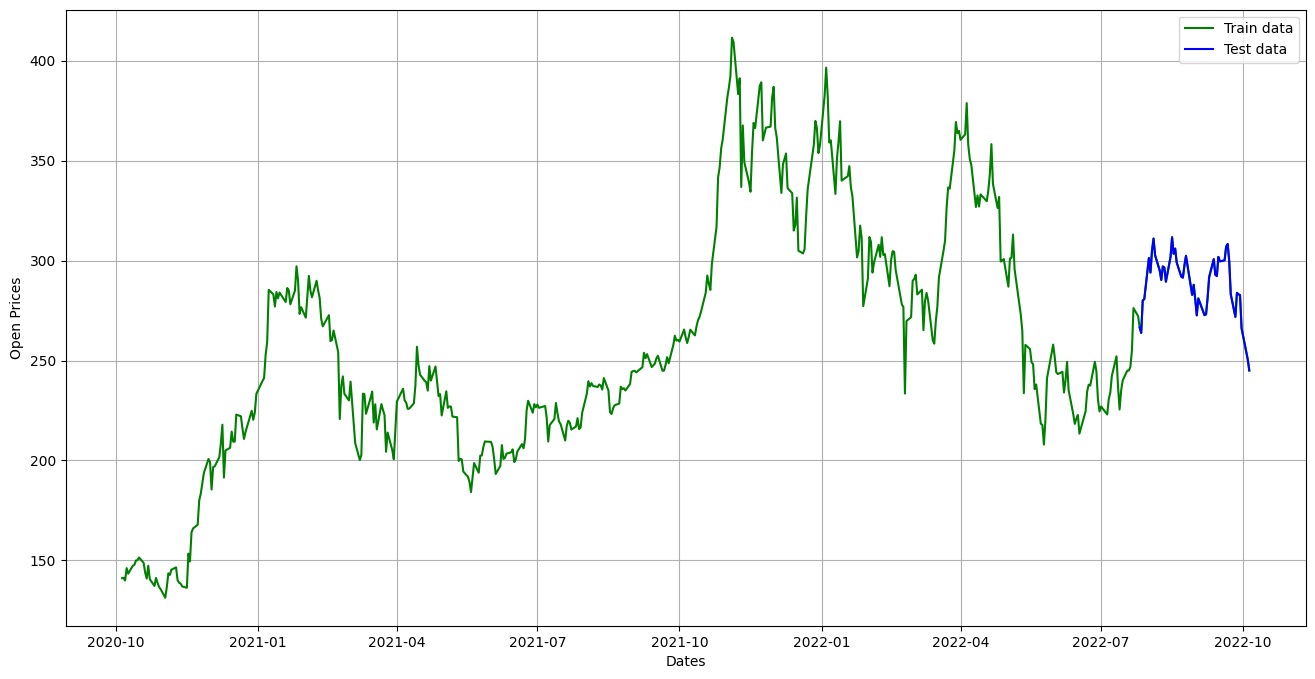

In [ ]:
# Splits the dataset:
# 90% of the data is used for training, and the remaining 10% is used for testing
train_data, test_data = data[0:int(len(data) * 0.9)], data[int(len(data) * 0.9):]

# Creates a plot to visualize training and testing data
plt.figure(figsize=(16,8))  # Sets the figure size
plt.grid(True)  # Adds a grid for better readability
plt.xlabel('Dates')  # Labels the x-axis as 'Dates'
plt.ylabel('Open Prices')  # Labels the y-axis as 'Open Prices'

# Plots the entire dataset in green (Training data)
plt.plot(data['Open'], 'green', label='Train data')

# Plots only the test data in blue
plt.plot(test_data['Open'], 'blue', label='Test data')

plt.legend()  # Displays the legend to differentiate train and test data

# LSTM


This prepares the training data for preprocessing and feeding into the ML model.

In [ ]:
train = train_data.iloc[:, 0:1].values  # Selecting 'Open' prices as a NumPy array


Ensures all values lie within the same scale to enhance model performance.
Helps prevent issues with gradient updates in deep learning models like LSTMs.

In [ ]:
from sklearn.preprocessing import MinMaxScaler  # Imports MinMaxScaler for normalization

scaler = MinMaxScaler()  # Initializes the MinMaxScaler (default range: 0 to 1)
train_scaled = scaler.fit_transform(train)  # Fits the scaler to the training data and transforms it

Prepares sequential data required for time-series models like LSTM and GRU.
Helps the model learn patterns in historical data for better cryptocurrency price predictions.

In [ ]:
timesteps = 7  # Defines the number of previous time steps to consider for prediction

X_train = []  # List to store input sequences (features)
y_train = []  # List to store target values (labels)

# Loops through the training data, starting from 'timesteps' index to the end
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])  # Stores the past 'timesteps' values as input
    y_train.append(train_scaled[i, 0])  # Stores the current value as the target (label)

# Converts lists into NumPy arrays for compatibility with ML models
X_train, y_train = np.array(X_train), np.array(y_train)

Seed:
Ensures consistent results when running the code multiple times.
Useful in deep learning to get repeatable experiments.

Reshaping makes the data compatible with LSTM/GRU.
Setting a seed ensures reproducibility in experiments.

In [ ]:
# Reshapes X_train to be compatible with LSTM/GRU models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

from numpy.random import seed  # Imports function to set a fixed random seed
seed(2019)  # Sets the random seed for reproducibility

Stacked LSTM layers:
Helps the model capture complex time-series patterns.
Each layer processes sequential dependencies in the data.

Dropout Regularization:
Helps prevent overfitting by randomly deactivating neurons.

Final Dense Layer:
Outputs a single price prediction (since it's a regression problem).

In [ ]:
# Initializes a Sequential model
model = Sequential()

# First LSTM layer with 50 units and return_sequences=True (allows stacking more LSTMs)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Dropout layer to prevent overfitting (20% of neurons are dropped during training)
model.add(Dropout(0.20))

# Second LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))  # 25% dropout to further reduce overfitting

# Third LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # 20% dropout

# Fourth LSTM layer (final LSTM), does not return sequences as it's the last one
model.add(LSTM(units=50))
model.add(Dropout(0.25))  # 25% dropout

# Output layer: Dense layer with 1 neuron (predicts the next price)
model.add(Dense(units=1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Minimizes prediction error to make the model more accurate.
Ensures stable training with Adam optimizer

In [ ]:
# Compiles the model with Adam optimizer and Mean Squared Error loss
model.compile(optimizer='adam', loss='mean_squared_error')

Layer Type:
Lists each layer in the model (LSTM, Dropout, Dense, etc.).

Output Shape:
Shows how data flows through each layer and its dimensions.

Number of Parameters:
Indicates the total number of trainable and non-trainable parameters in the model.

In [ ]:
model.summary()  # Displays the model's architecture

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 7, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

epochs=40:
The model trains for 40 full passes over the dataset.
More epochs allow the model to learn better but can lead to overfitting if too high.

batch_size=32:
The data is split into batches of 32 samples each before updating weights.
A good balance between efficient training and stable gradient updates.

X_train, y_train:
X_train: Features (past 7 days of prices).
y_train: Labels (next day's price).

In [ ]:
# Trains the model on the training data
model.fit(X_train, y_train, epochs=40, batch_size=32)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1911
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0401
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0205
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0147
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0099
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0111
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0084
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0105
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0105
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0093
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0071
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0092
Epoch 13/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0090
Epoch 14/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0083
Epoch 15/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0088
Epoc

Stores the actual stock prices from the test dataset.
Used for comparison with the model's predicted prices.

In [ ]:
real_stock_price = test_data.iloc[:, 0:1].values  # Selecting the 'Open' prices as a NumPy array

This provides the required context for the LSTM model to predict accurately.

Prepares test data for making predictions with the trained LSTM model.
Ensures time-series continuity by including the last timesteps days from training data.
Normalizes test data for compatibility with the trained model.

In [ ]:
# Combines training and test data to ensure continuity in time series
combine = pd.concat((train_data['Open'], test_data['Open']), axis=0)

# Extracts the last 'timesteps' days from train data + all test data
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values

# Reshapes into a 2D array (required for scaling and model input)
test_inputs = test_inputs.reshape(-1, 1)

# Scales the test inputs using the same MinMaxScaler used for training
test_inputs = scaler.transform(test_inputs)

Verifying data size before processing.

In [ ]:
test_data.shape

(51, 6)

Prepares test data to match LSTM input requirements.

Generates stock price predictions based on historical patterns.

Converts predictions back to real-world prices.

In [ ]:
# Creating the test dataset (same way as training)
X_test = []
for i in range(timesteps, test_data.shape[0] + timesteps):
    X_test.append(test_inputs[i - timesteps:i, 0])  # Using past 'timesteps' days to predict

# Converting the list to a NumPy array
X_test = np.array(X_test)

# Reshaping into 3D format required for LSTM: (samples, timesteps, features)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predicting stock prices using the trained model
predicted_stock_price = model.predict(X_test)

# Converting predictions back to the original scale
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step


Compares model predictions with real data to assess accuracy.

Visualizes stock trends and prediction errors.

Evaluates whether the model captures market movements.

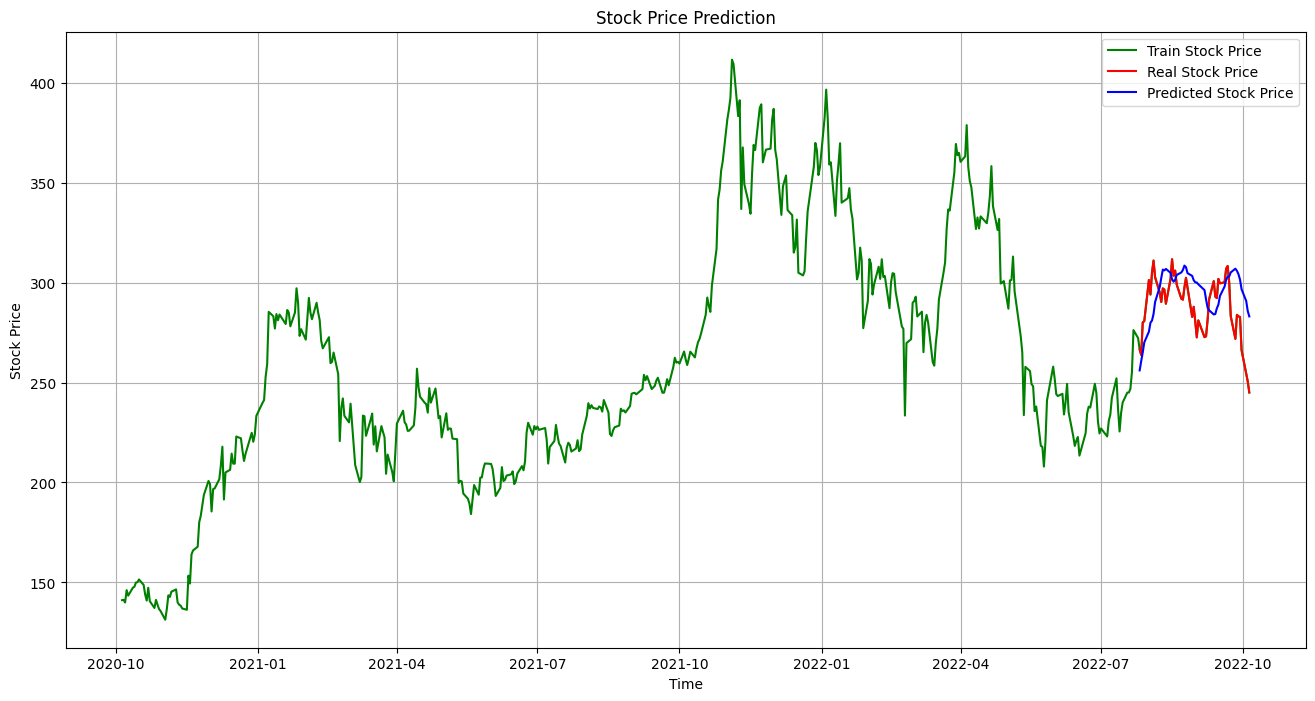

In [ ]:
plt.figure(figsize=(16,8))  # Set figure size

# Plot training data (last 600 days) in green
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Train Stock Price')

# Plot actual test stock prices in red
plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')

# Plot predicted stock prices in blue
plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')

# Titles and labels
plt.title('Stock Price Prediction')  # Graph title
plt.xlabel('Time')  # X-axis label
plt.ylabel('Stock Price')  # Y-axis label

# Show legend to differentiate the plots
plt.legend()

# Enable grid for better readability
plt.grid(True)

# Save the figure as a PDF (optional, currently commented)
# plt.savefig('lstm_30.pdf')

# Display the plot
plt.show()

MSE & RMSE → Detect large errors (important for finance).

MAE → Measures overall prediction accuracy.

Compare values to determine model performance.

In [ ]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: ' + str(mse))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: ' + str(mae))

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: ' + str(rmse))

MSE: 309.26949056014234
MAE: 14.663465312882966
RMSE: 17.586059551819513


# LSTM + CPD

This is a deep LSTM model with 4 layers and dropout regularization.

Stacking LSTMs enhances learning, but:
If overfitting occurs, increase dropout.
If underfitting occurs, add more epochs or layers.

In [ ]:
model = Sequential()  # Initialize the Sequential model

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# LSTM with 50 neurons, returning sequences for stacking layers
model.add(Dropout(0.20))  # Dropout (20%) to reduce overfitting


model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.25))  # Higher dropout (25%) for stronger regularization

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Dropout at 20%

model.add(LSTM(units=50))  # Last LSTM layer, does not return sequences
model.add(Dropout(0.25))  # Dropout at 25%


# Adding the output layer
model.add(Dense(units=1))  # Fully connected layer for final price prediction
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 7, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 7, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 7, 50)               │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras

# Save the best model based on validation loss
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)

# Stop training if validation loss doesn't improve for 50 epochs
early_stopping = keras.callbacks.EarlyStopping(patience=50)


In [ ]:
model.fit(X_train, y_train, epochs=40, batch_size=32, callbacks=[early_stopping, model_checkpoint])
# Train the model for 40 epochs with a batch size of 32
# Apply early stopping to halt training if no improvement occurs
# Save the best model using model checkpointing


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0092
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0064
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0076
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0065
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0079
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0075
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0078
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0079
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0078
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0065
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0063
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0070
Epoch 13/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082
Epoch 14/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0066
Epoch 15/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0077
Epoc

prepares test data for prediction by scaling and reshaping it appropriately

In [ ]:
real_stock_price = test_data.iloc[:, 0:1].values  # Extract actual stock prices from the test dataset

combine = pd.concat((train_data['Open'], test_data['Open']), axis=0)  # Merge train and test data for continuity

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values  # Extract required test inputs including past timesteps

test_inputs = test_inputs.reshape(-1, 1)  # Reshape into a 2D array for scaling

test_inputs = scaler.transform(test_inputs)  # Normalize test inputs using the same scaler as training data


Prepares the test data in the required format for the LSTM model, makes predictions, and then inverse transforms the predictions to get the actual stock price values.

In [ ]:
X_test = []  # Initialize an empty list for test input sequences

for i in range(timesteps, test_data.shape[0] + timesteps):
    X_test.append(test_inputs[i - timesteps:i, 0])  # Create sequences of past 'timesteps' days' prices

X_test = np.array(X_test)  # Convert to NumPy array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape to match LSTM input format

predicted_stock_price = model.predict(X_test)  # Make predictions on test data

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)  # Convert predictions back to actual price scale

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


Visualizes the stock price prediction by plotting the training data, real stock prices, and predicted prices to compare model performance.

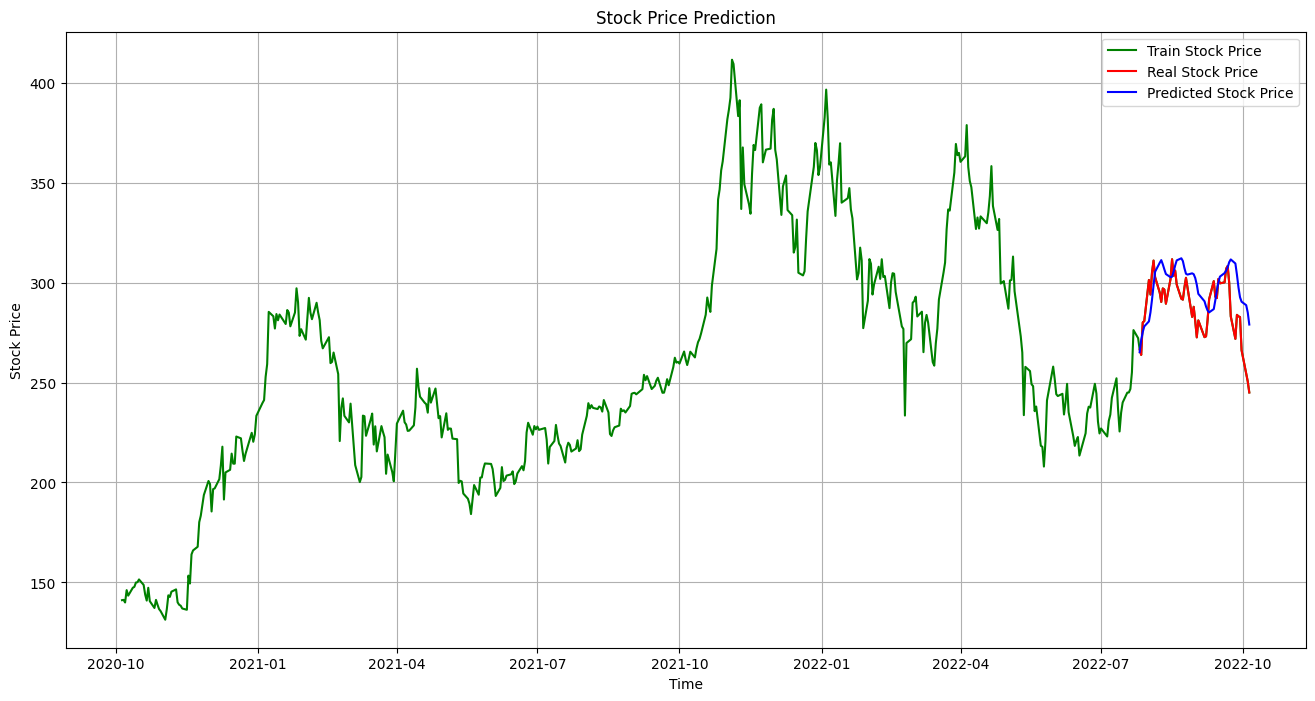

In [ ]:
plt.figure(figsize=(16,8))  # Set figure size

plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Train Stock Price')  # Plot last 600 training prices
plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')  # Plot actual stock prices from test data
plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')  # Plot model's predicted prices

plt.title('Stock Price Prediction')  # Set title
plt.xlabel('Time')  # Label x-axis
plt.ylabel('Stock Price')  # Label y-axis
plt.legend()  # Show legend for better understanding
plt.grid(True)  # Enable grid for better visualization

# plt.savefig('lstm_30.pdf')  # (Optional) Save the plot as a PDF
plt.show()  # Display the plot

In [ ]:
mse = mean_squared_error(real_stock_price, predicted_stock_price)  # Compute Mean Squared Error
print('MSE: ' + str(mse))  # Print MSE

mae = mean_absolute_error(real_stock_price, predicted_stock_price)  # Compute Mean Absolute Error
print('MAE: ' + str(mae))  # Print MAE

rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))  # Compute Root Mean Squared Error
print('RMSE: ' + str(rmse))  # Print RMSE


MSE: 261.0977562882061
MAE: 12.819143856272978
RMSE: 16.158519619327944


# Machine Learning  Model

In [ ]:
df = pd.read_csv('data/TSLA.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
Date         1259 non-null object
Open         1259 non-null float64
High         1259 non-null float64
Low          1259 non-null float64
Close        1259 non-null float64
Adj Close    1259 non-null float64
Volume       1259 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to DateTime format
df.set_index('Date', inplace=True)  # Set 'Date' as the index for time series operations

In [ ]:
data = df.filter(['Close'])  # Select only the 'Close' price column
dataset = data.values  # Convert the DataFrame to a NumPy array

Calculates the length of the training dataset, setting it to 80% of the total data for training the model.

In [ ]:
training_data_len = math.ceil(len(dataset) * 0.8)  # Compute 80% of the dataset length, rounding up
training_data_len  # Output the training data length

80000

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

ValueError: Found array with 0 feature(s) (shape=(100000, 0)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

In [ ]:
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.03595933, 0.02954091, 0.02828875, 0.02898298, 0.02786284,
       0.03049068, 0.02839949, 0.0295111 , 0.02894465, 0.02694289,
       0.0298646 , 0.02754767, 0.03746279, 0.03752241, 0.0377737 ,
       0.03477958, 0.03101881, 0.03211766, 0.02950259, 0.02705362,
       0.03008608, 0.02995404, 0.03296521, 0.03327612, 0.03251375,
       0.0315512 , 0.03176416, 0.03661523, 0.03745427, 0.03687929,
       0.03983083, 0.03761611, 0.03792277, 0.0369304 , 0.03724984,
       0.03537159, 0.03443459, 0.03552065, 0.03124028, 0.0319047 ,
       0.03297373, 0.0386894 , 0.03821239, 0.03696447, 0.03785888,
       0.03674727, 0.03664079, 0.03701132, 0.03632136, 0.03983083,
       0.04021415, 0.04103189, 0.03396183, 0.03397035, 0.03210062,
       0.0306568 , 0.02867633, 0.02733472, 0.02823764, 0.02412338])]
[0.026623452971367048]



In [ ]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1]))
x_train.shape

(948, 60)

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)
val1 = model.score(x_train,y_train)
val1

0.9808361491205961

In [ ]:
y_pred = model.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.9804617204447594

# Lasso Regression

In [ ]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train,y_train)
val2 = clf.score(x_train,y_train)
val2

0.0

In [ ]:
y_pred = clf.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

-1.184826486288865e+31

# Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(x_train,y_train)
val3 = clf.score(x_train,y_train)
val3

0.8948435386548395

In [ ]:
y_pred = clf.predict(x_train)

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.8608956836721915

# XGBooster Regression

In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(x_train,y_train)
val4 = model.score(x_train,y_train)
val4

0.9991262932837692

In [ ]:
y_pred = model.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.9991224558480675

# Voting Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , VotingRegressor

In [ ]:
r1 = DecisionTreeRegressor()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = SVR(C=1.0, epsilon=0.2)
er = VotingRegressor([('dt', r1), ('rf', r2), ('sv', r3)])

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'dt': [1.0, 100.0],
          'rf': [1.0, 100.0],
      'sv': [2,3,4],}
grid = GridSearchCV(estimator=er, param_grid=params, cv=2)

In [ ]:
er.fit(x_train,y_train)

VotingRegressor(estimators=[('dt', DecisionTreeRegressor()),
                            ('rf',
                             RandomForestRegressor(n_estimators=10,
                                                   random_state=1)),
                            ('sv', SVR(epsilon=0.2))])

In [ ]:
val5 = er.score(x_train,y_train)
val5

0.8825396818266217

In [ ]:
y_pred = er.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.7343916942261474

# MLP-ANN

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(random_state=1, max_iter=500)
model.fit(x_train,y_train)
val6 = model.score(x_train,y_train)
val6

0.6532533869983793

In [ ]:
y_pred = model.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.8099383914639365

# Deep Learning

In [ ]:
data = pd.read_csv("data/TSLA.csv")

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-19,45.299999,46.230000,44.987999,45.619999,45.619999,12539500
1,2015-10-20,45.543999,45.720001,40.400002,42.605999,42.605999,74500000
2,2015-10-21,42.397999,42.962002,41.759998,42.018002,42.018002,20757500
3,2015-10-22,42.312000,43.150002,41.880001,42.344002,42.344002,14126000
4,2015-10-23,43.000000,43.070000,41.537998,41.818001,41.818001,21177500


In [ ]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 1259
Train data length : 881
Validation data lenth : 378


In [ ]:
train_data = data[:length_train].iloc[:,:2]
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
0,2015-10-19,45.299999
1,2015-10-20,45.543999
2,2015-10-21,42.397999
3,2015-10-22,42.312000
4,2015-10-23,43.000000
...,...,...
876,2019-04-12,54.043999
877,2019-04-15,53.726002
878,2019-04-16,53.150002
879,2019-04-17,54.950001


In [ ]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
881,2019-04-22,53.799999
882,2019-04-23,52.029999
883,2019-04-24,52.770000
884,2019-04-25,51.000000
885,2019-04-26,49.299999
...,...,...
1254,2020-10-12,442.000000
1255,2020-10-13,443.350006
1256,2020-10-14,449.779999
1257,2020-10-15,450.309998


In [ ]:
dataset_train = train_data.Open.values
dataset_train.shape

(881,)

In [ ]:
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(881, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(881, 1)

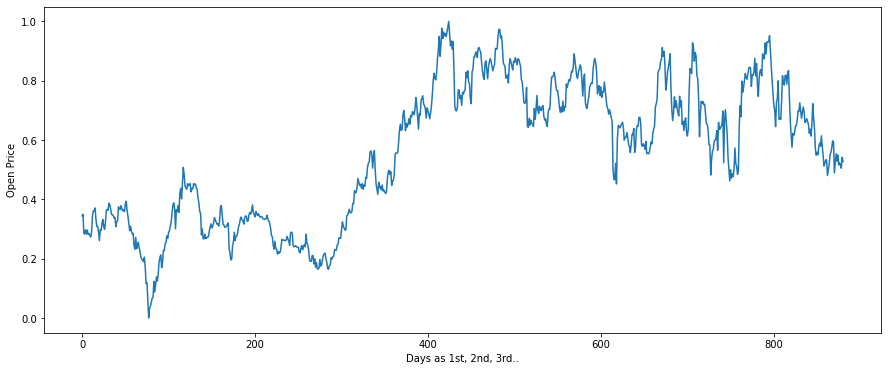

In [ ]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

In [ ]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (831, 50)
Shape of y_train before reshape : (831,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (831, 50, 1)
Shape of y_train after reshape : (831, 1)


# RNN

In [ ]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True,
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = ["accuracy"])


In [ ]:
# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
26/26 [==============================] - 1s 44ms/step - loss: 0.4270 - accuracy: 0.0012
Epoch 2/100
26/26 [==============================] - 1s 38ms/step - loss: 0.2690 - accuracy: 0.0012
Epoch 3/100
26/26 [==============================] - 1s 37ms/step - loss: 0.2261 - accuracy: 0.0024
Epoch 4/100
26/26 [==============================] - 1s 38ms/step - loss: 0.1996 - accuracy: 0.0012
Epoch 5/100
26/26 [==============================] - 1s 40ms/step - loss: 0.1744 - accuracy: 0.0024
Epoch 6/100
26/26 [==============================] - 1s 39ms/step - loss: 0.1588 - accuracy: 0.0024
Epoch 7/100
26/26 [==============================] - 1s 39ms/step - loss: 0.1551 - accuracy: 0.0024
Epoch 8/100
26/26 [==============================] - 1s 38ms/step - loss: 0.1335 - accuracy: 0.0012
Epoch 9/100
26/26 [==============================] - 1s 37ms/step - loss: 0.1125 - accuracy: 0.0012
Epoch 10/100
26/26 [==============================] - 1s 39ms/step - loss: 0.1006 - accuracy: 0.0012

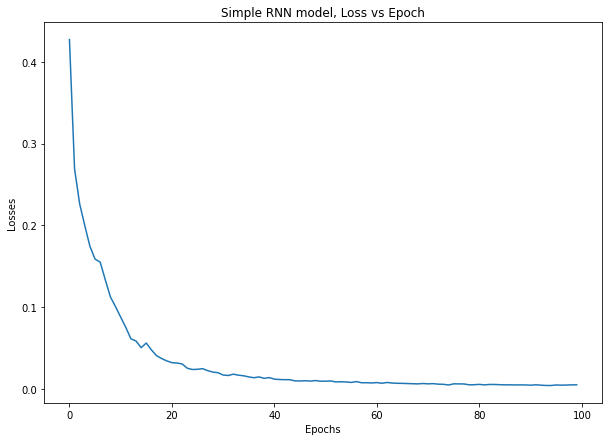

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

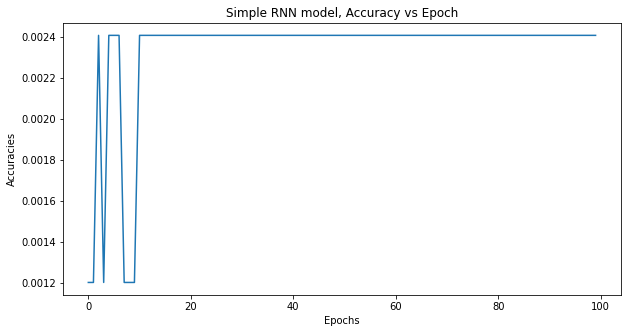

In [ ]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

# CNN

In [ ]:
import keras
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

In [ ]:
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# save best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)


In [ ]:
# sav history
history = model.fit(X_train, y_train, epochs=20)

Epoch 1/20
26/26 [==============================] - 0s 6ms/step - loss: 0.1457 - mae: 0.4584
Epoch 2/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1629 - mae: 0.4973
Epoch 3/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1337 - mae: 0.4284
Epoch 4/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1232 - mae: 0.3986
Epoch 5/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1970 - mae: 0.5553
Epoch 6/20
26/26 [==============================] - 0s 3ms/step - loss: 0.1791 - mae: 0.5432
Epoch 7/20
26/26 [==============================] - 0s 2ms/step - loss: 0.1278 - mae: 0.4055
Epoch 8/20
26/26 [==============================] - 0s 2ms/step - loss: 0.1258 - mae: 0.4129
Epoch 9/20
26/26 [==============================] - 0s 2ms/step - loss: 0.1291 - mae: 0.4179
Epoch 10/20
26/26 [==============================] - 0s 2ms/step - loss: 0.1474 - mae: 0.4675
Epoch 11/20
26/26 [==============================] - 0s 2ms/step - lo

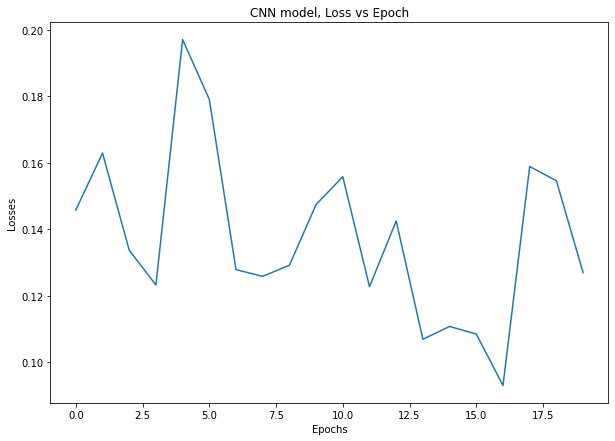

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("CNN model, Loss vs Epoch")
plt.show()

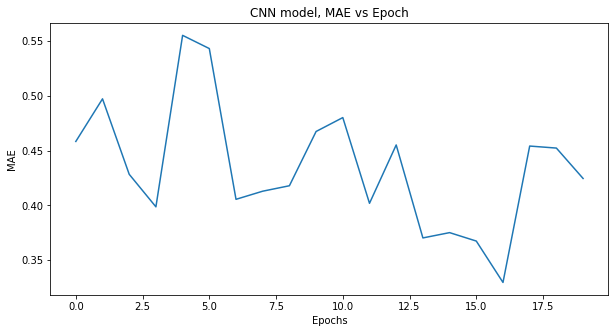

In [ ]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["mae"])
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("CNN model, MAE vs Epoch")
plt.show()

For Attention

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
class DataLoader():

    def __init__(self, filename,cols):
        dataframe = pd.read_csv(filename)
        self.data_train = dataframe.get(cols).values
        self.len_train  = len(self.data_train)
        self.len_train_windows = None

    def get_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

In [ ]:
data = DataLoader(
        "data/EURCAD_mid_price_H4.csv",
        ["close","volume"]
    )

x, y = data.get_data(
        seq_len=20,
        normalise=True
    )


In [ ]:
x_train = x[:-1500]
x_test = x[-500:]
y_train = y[:-1500]
y_test = y[-500:]

# Attention+ CPD+ LSTM

In [ ]:
from attention import Attention
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, LSTM,Bidirectional

model = Sequential([
      #Bidirectional(LSTM(units=100,input_shape=(None, 2), return_sequences=True)),
      LSTM(units=100,input_shape=(19, 2), return_sequences=True),
      Dropout(0.2),
      LSTM(units=100,return_sequences=True),
      LSTM(units=50,return_sequences=True),
      Dropout(0.2),
      Attention(),
      Dense(1, activation='linear')
])
model.compile(loss='mse', optimizer='adam')

model.fit(x_train, y_train, epochs=20,
              batch_size=32)

Epoch 1/20
770/770 [==============================] - 3s 4ms/step - loss: 1.4853e-04
Epoch 2/20
770/770 [==============================] - 3s 3ms/step - loss: 3.5575e-05
Epoch 3/20
770/770 [==============================] - 3s 3ms/step - loss: 2.8109e-05
Epoch 4/20
770/770 [==============================] - 3s 3ms/step - loss: 2.3186e-05
Epoch 5/20
770/770 [==============================] - 3s 3ms/step - loss: 1.9437e-05
Epoch 6/20
770/770 [==============================] - 3s 3ms/step - loss: 1.7502e-05
Epoch 7/20
770/770 [==============================] - 2s 3ms/step - loss: 1.5610e-05
Epoch 8/20
770/770 [==============================] - 9s 12ms/step - loss: 1.4453e-05
Epoch 9/20
770/770 [==============================] - 34s 44ms/step - loss: 1.3272e-05
Epoch 10/20
770/770 [==============================] - 159s 206ms/step - loss: 1.2843e-05
Epoch 11/20
770/770 [==============================] - 249s 323ms/step - loss: 1.1950e-05
Epoch 12/20
770/770 [==============================]

In [ ]:
from numpy import newaxis
def predict_sequences_multiple(model, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 20 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [ ]:
predictions = predict_sequences_multiple(model,x_test,19, 15)

[Model] Predicting Sequences Multiple...


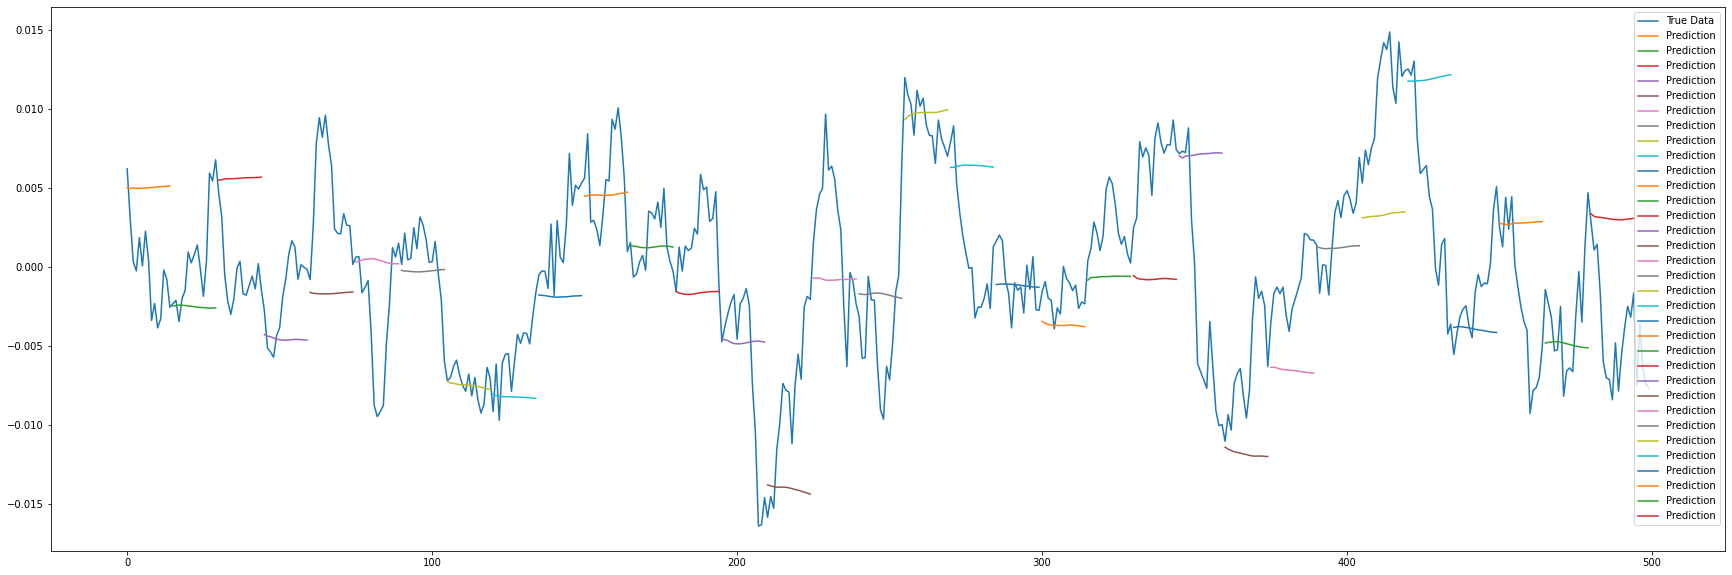

In [ ]:
plt.rcParams["figure.figsize"] = [30,10]
plot_results_multiple(predictions, y_test,15)